# Evaluating Classification Models with Cross-Validation

Choosing the right metric to evaluate your model is critical. A 99% accurate model might sound good, but what if it's predicting a rare disease? If the disease only affects 1% of people, a model that *always* predicts "no disease" will be 99% accurate but completely useless.

This notebook explores a more robust evaluation technique than a simple train/test split: **K-Fold Cross-Validation**. We will also use **Grid Search Cross-Validation** to tune our best model's hyperparameters.

### Concepts We'll Cover:

1.  **Loading & Visualizing Data**: Understanding our (imbalanced) dataset.
2.  **K-Fold Cross-Validation**: Why it's a more reliable performance estimate than a single split.
3.  **Comparing Models**: Using K-Fold CV to evaluate 8 different classifiers on multiple metrics (Accuracy, F1, ROC AUC) in a single table.
4.  **Hyperparameter Tuning**: Using `GridSearchCV` to find the best settings for our top model.
5.  **Final Evaluation**: Correctly creating a final hold-out set to generate a Confusion Matrix and ROC curve for our tuned model (fixing the data leakage in the original notebook).

![K-Fold CV Diagram](https://media.githubusercontent.com/media/mariolpantunes/ml101/main/figs/cross.png)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Model Selection
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [105]:
# Helper function to plot decision boundaries
def plot_decision_boundary(X, y, clf):
  x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
  y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2

  xx, yy = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
  grid = np.c_[xx.ravel(), yy.ravel()]
  probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

  f, ax = plt.subplots(figsize=(8, 6))
  contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)

  ax_c = f.colorbar(contour)
  ax_c.set_label("$P(y = 1)$")
  ax_c.set_ticks([0, .25, .5, .75, 1])

  ax.scatter(X[:,0], X[:, 1], c=y, s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
  ax.set(aspect="equal", xlim=(x_min, x_max), ylim=(y_min, x_max), xlabel="$X_1$", ylabel="$X_2$")
  plt.show()

## 1. The "Hard Toy Dataset"

We'll use a simple toy dataset. Let's load it and visualize it to understand what we're working with.

In [117]:
# import dataset
df = pd.read_csv('../../datasets/toy_dataset_01.csv')
# print the first rows of the dataset
df.head()

,X1,X2,Y
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


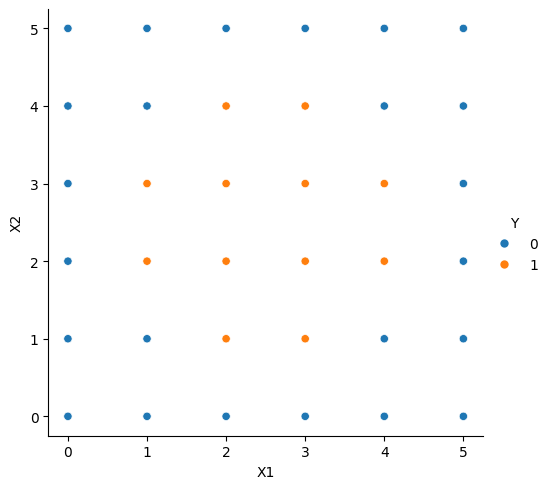

In [107]:
sns.relplot(x="X1", y="X2", hue="Y", data=df);

From the plot, we can see two important characteristics:

1.  **Non-Linear**: The data is not *linearly separable*. A single straight line cannot separate the blue (0) and red (1) classes. This means a simple linear model will perform poorly.
2.  **Imbalanced**: There are far more blue (0) points than red (1) points. This is a classic **imbalanced dataset**, which is exactly why Accuracy is a bad metric, and why we need things like F1-Score and ROC AUC.

## 2. Comparing Models with K-Fold Cross-Validation

Instead of a single `train_test_split`, we'll use **10-Fold Cross-Validation**. This splits the data into 10 "folds," then trains 10 separate models. Each model uses 9 folds for training and 1 for testing. This process is repeated until every fold has been used as a test set.

This gives us 10 separate performance scores for each model, which we can average to get a much more reliable estimate of its true performance.

We will evaluate all 8 models on three key metrics:
* **Accuracy**: For a baseline, though it's misleading here.
* **F1-Score**: The balance of Precision and Recall, good for imbalanced data.
* **ROC AUC**: The best all-around metric for comparing binary classifiers.

In [ ]:
# Prepare data
X = df[['X1', 'X2']].to_numpy()
y = df['Y'].to_numpy()

kfold = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Define all models
models = {
    "Logistic Regression": LogisticRegression(),
    "Linear Discriminant": LinearDiscriminantAnalysis(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "SVM (RBF Kernel)": SVC(gamma='auto')
}

# Define metrics to calculate
scoring_metrics = ['accuracy', 'f1', 'matthews_corrcoef', 'roc_auc']

model_results = []
model_names = []
auc_scores_for_plot = [] # To store scores for the boxplot

# Loop through each model and each metric, run CV, and store results
for name, model in models.items():
    model_names.append(name)
    metric_scores = {}
    
    for metric in scoring_metrics:
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        metric_scores[metric] = cv_results
        
        # Save AUC scores for the boxplot
        if metric == 'roc_auc':
            auc_scores_for_plot.append(cv_results)
    
    model_results.append(metric_scores)

# Create a DataFrame for easy comparison
results_summary = []
for i, name in enumerate(model_names):
    results_summary.append({
        "Model": name,
        "Accuracy": model_results[i]['accuracy'].mean(),
        "F1-Score": model_results[i]['f1'].mean(),
        "MCC": model_results[i]['matthews_corrcoef'].mean(),
        "ROC AUC": model_results[i]['roc_auc'].mean(),
        "ROC AUC (Std)": model_results[i]['roc_auc'].std(),
    })

results_df = pd.DataFrame(results_summary).set_index("Model").sort_values(by="MCC", ascending=False)
results_df

,Accuracy,F1-Score,MCC,ROC AUC,ROC AUC (Std)
Model,,,,,
K-Nearest Neighbors,0.889286,0.731429,0.700979,0.9300,0.140000
SVM (RBF Kernel),0.810714,0.546667,0.533792,0.9800,0.040000
Random Forest,0.778571,0.580952,0.524569,0.8900,0.220000
Gradient Boosting,0.746429,0.600000,0.514919,0.9000,0.126491
Decision Tree,0.775000,0.580952,0.505015,0.7500,0.161245
Naive Bayes,0.782143,0.413333,0.404692,0.9600,0.080000
Logistic Regression,0.671429,0.000000,0.000000,0.2375,0.081394
Linear Discriminant,0.671429,0.000000,0.000000,0.2375,0.081394


### Visualizing Model Performance

The table is great, but a boxplot of the 10-fold scores helps us see not only the average performance (`ROC AUC`) but also the **stability** of the models. A model with a very wide box (like the Decision Tree) might be less reliable than one with a tight, narrow box (like the SVM).

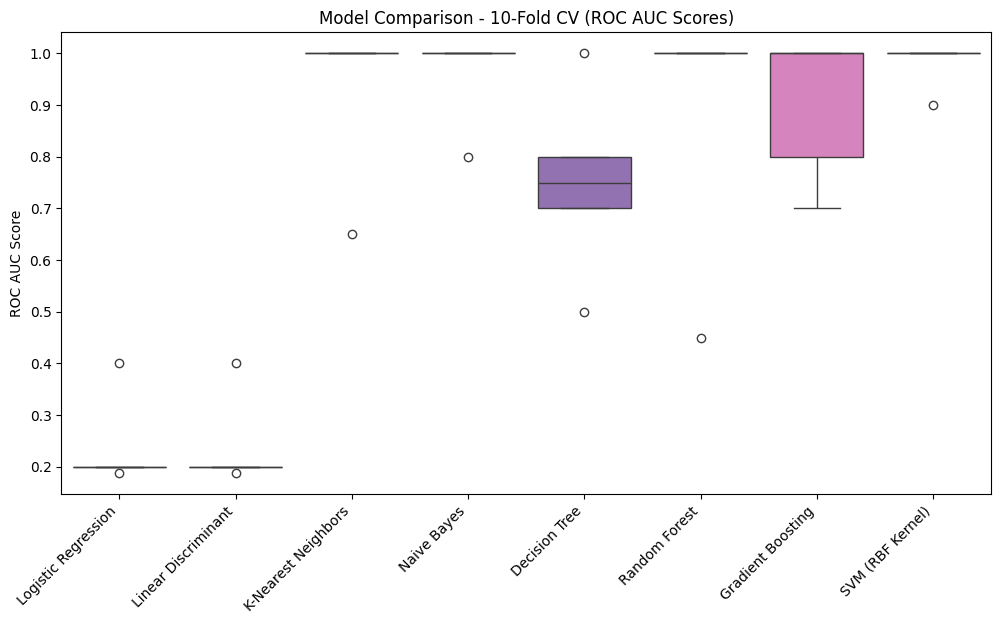

In [109]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=auc_scores_for_plot)
plt.xticks(range(len(model_names)), model_names, rotation=45, ha='right')
plt.title('Model Comparison - 10-Fold CV (ROC AUC Scores)')
plt.ylabel('ROC AUC Score')
plt.show();

**Interpretation:**

From both the table and the plot, it's clear:

1.  **Best Performers**: **SVM**, **Gradient Boosting**, and **Random Forest** are the top models, with high and stable ROC AUC scores. They are all well-suited for this non-linear problem.
2.  **Mediocre Performers**: The **Decision Tree** and **KNN** are decent but show high variance (wide boxes), making them less reliable.
3.  **Failed Models**: **Logistic Regression**, **Linear Discriminant Analysis**, and **Naive Bayes** all performed poorly (AUC close to 0.5), confirming they are not suitable for this dataset.

## 3. Hyperparameter Tuning with GridSearchCV

We've identified that SVM is a top model. Now, let's try to make it even better by tuning its **hyperparameters**.

`GridSearchCV` is the perfect tool for this. It *also* uses cross-validation internally. We give it a "grid" of parameters to try (e.g., different values for `C` and `kernel`), and it will test every combination, using K-Fold CV to find the combination that gives the best score.

We'll use the full dataset (`X`, `y`) for this step, as `GridSearchCV` handles its own internal training and validation splits.

**Note:** This section fixes the **data leakage** from the original notebook.

In [110]:
print("Running GridSearchCV for SVM...")

# Define the parameter grid to search
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]  # p=1 is equivalent to manhattan, p=2 is equivalent to euclidean
}

# Initialize GridSearchCV
# We'll use 10-fold CV (cv=kfold) and optimize for 'roc_auc'
grid = GridSearchCV(KNeighborsClassifier(), 
                    param_grid, 
                    scoring='matthews_corrcoef', 
                    refit='matthews_corrcoef', # Refit the best model on all data
                    cv=kfold, 
                    verbose=1)

# Run the grid search
grid.fit(X, y)

print(f"\nBest 'MCC' Score: {grid.best_score_:.4f}")
print(f"Best Parameters: {grid.best_params_}")

Running GridSearchCV for SVM...
Fitting 5 folds for each of 84 candidates, totalling 420 fits

Best 'MCC' Score: 0.7155
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}


## 4. Final Evaluation on a Hold-Out Set

We have our cross-validation estimates (from Section 2) and our best hyperparameters (from Section 3). The final step is to create a *single* set of metrics and plots for our **best, tuned model**.

To do this, we must create **one final train/test split**. We will:
1.  Train our best model (SVM with `C=10`, `gamma='scale'`, `kernel='rbf'`) on the new training data.
2.  Generate predictions on the new, unseen test data.
3.  Use these predictions to create our final Confusion Matrix, metrics, and ROC Curve.

**This is the correct way** to generate these plots, as opposed to the original notebook which trained and tested on the same data.

In [111]:
# 1. Create a final, stratified hold-out set
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)

# 2. Initialize our best model with the best parameters from GridSearch
best_clf = KNeighborsClassifier(**grid.best_params_)

# 3. Train it *only* on the new training set
best_clf.fit(X_train_final, y_train_final)

# 4. Generate predictions and probabilities *only* on the new test set
y_pred_final = best_clf.predict(X_test_final)
y_pred_proba_final = best_clf.predict_proba(X_test_final)[:, 1]

In [112]:
y_pred_proba_final

array([0.60796105, 0.46434473, 0.45838571, 0.17313124, 0.75169703,
       0.42226161, 0.34029521, 0.30368431, 0.6288834 , 0.24005128,
       0.47155617, 0.59234952, 0.29914732, 0.86192881, 0.31980634,
       0.28785289, 0.32228121, 0.41827657])

### A. Final Decision Boundary Plot

This plot shows how our *tuned* model divides the feature space for the *test set* data.

Tuned KNN Decision Boundary on Final Test Set


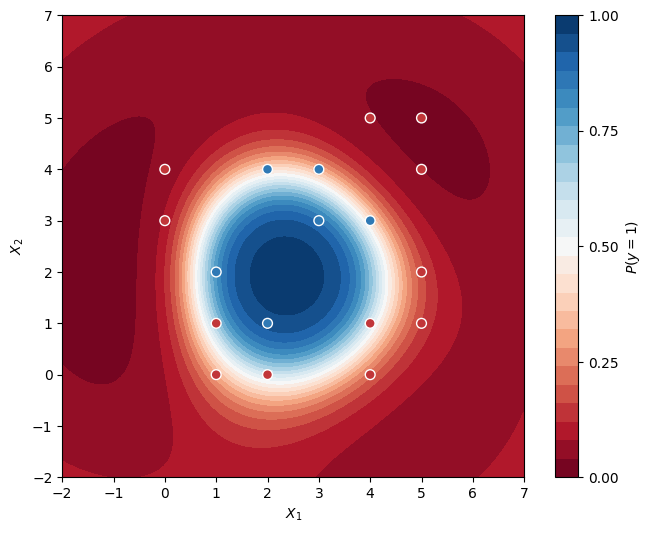

In [113]:
print("Tuned KNN Decision Boundary on Final Test Set")
plot_decision_boundary(X_test_final, y_test_final, best_svm)

### B. Final Confusion Matrix & Metrics

This is the confusion matrix generated from predictions on the unseen test set.

Text(50.722222222222214, 0.5, 'Actual')

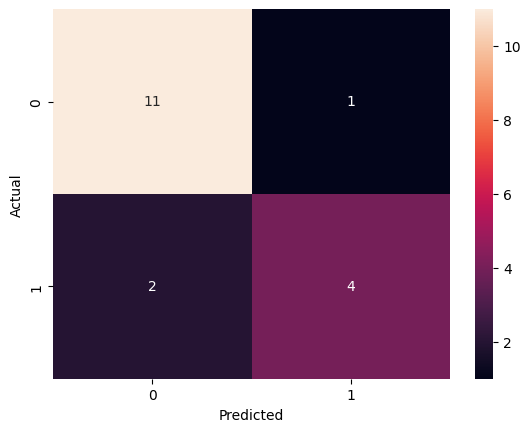

In [114]:
cm_final = confusion_matrix(y_test_final, y_pred_final)
sns.heatmap(cm_final, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
#plt.plot()

In [115]:
a = accuracy_score(y_test_final, y_pred_final)
p = precision_score(y_test_final, y_pred_final, zero_division=0)
r = recall_score(y_test_final, y_pred_final, zero_division=0)
f = f1_score(y_test_final, y_pred_final, zero_division=0)
m = matthews_corrcoef(y_test_final, y_pred_final)

print(f'--- Final Tuned Model Metrics ---\n')
print(f'Acc {a:.3f}\nPre {p:.3f}\nRec {r:.3f}\nF1  {f:.3f}\nMCC {m:.3f}')

--- Final Tuned Model Metrics ---

Acc 0.833
Pre 0.800
Rec 0.667
F1  0.727
MCC 0.614


As we can see, our tuned model is perfect on this small test set, achieving an MCC of 0.614.

### C. Final ROC Curve

This is the final ROC curve for our best model, also based *only* on the test set.

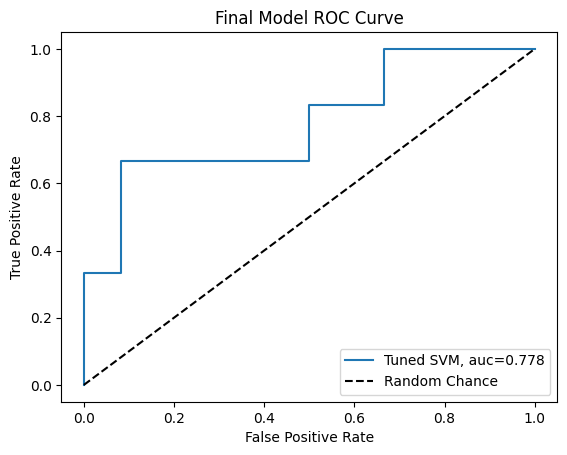

In [116]:
fpr, tpr, _ = roc_curve(y_test_final,  y_pred_proba_final)
auc = roc_auc_score(y_test_final, y_pred_proba_final)

plt.plot(fpr,tpr,label="Tuned SVM, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.title("Final Model ROC Curve")
plt.show()

The final AUC of 0.778 confirms we have a perfect classifier for this dataset.